In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Pollen-Adaptation/cyclegan

Mounted at /content/drive
/content/drive/My Drive/Pollen-Adaptation/cyclegan


In [2]:
## install section for Colab

! pip install dominate
! pip install visdom



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 676 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-py3-none-any.whl size=655250 sha256=1e6ef3ec67a658fa07107c58d32ec6a15d40a48ffac680633f37aa49cc2b0e32
  Stored in directory: /root/.cache/pip/wheels/2d/d1/9b/cde923274eac9cbb6ff0d8c7c72fe30a3da9095a38fd50bbf1
  Created wheel for torchfile: filename=torchfile-0.1.0-py3-none-any.whl size=5709 sha256=903667b86c33d5988be4fc9396620ef61caa74e2fd980d307f9fa394d0b39d03
  Stored in directory: /root/.cache/pip/wheels/ac/5c/3a/a80e1c65880945c71fd833408cd1e9a8cb7e2f8f37620bb75b
Successfully built visdom torchfile


In [3]:
import time
import argparse
import torch
from data import CreateDataLoader
from models import create_model
from util.visualizer import Visualizer
from options.train_options import TrainOptions
torch.cuda.is_available()
import matplotlib.pyplot as plt

In [ ]:
# python train.py --name cycada_svhn2mnist_noIdentity \
#     --resize_or_crop=None \
#     --loadSize=32 --fineSize=32 --which_model_netD n_layers --n_layers_D 3 \
#     --model cycle_gan_semantic \
#     --lambda_A 1 --lambda_B 1 --lambda_identity 0 \
#     --no_flip --batchSize 100 \
#     --dataset_mode mnist_svhn --dataroot /x/jhoffman/ \
#     --which_direction BtoA

In [4]:
### Loading parameters configuration
opt = TrainOptions()
opt.initialize()
trainOPT = opt.parser.parse_args(args=[ '--name', 'cycada_svhn2mnist_noIdentity',
                                       '--resize_or_crop', 'None',
                                       '--loadSize', '32',
                                       '--fineSize', '32',
                                       '--which_model_netD', 'n_layers',
                                       '--n_layers_D', '3',
                                       '--model', 'cycle_gan',
                                       '--lambda_A', '1',
                                       '--lambda_B', '1',
                                       '--lambda_identity', '0',
                                       '--no_flip',
                                       '--batchSize', '100',
                                       '--dataset_mode', 'pollen',
                                       '--which_direction', 'BtoA',
                                       '--dataroot', '/content/drive/My Drive/Pollen-Adaptation/Data',
                                        ])
trainOPT.isTrain = True
trainOPT.gpu_ids = [int(trainOPT.gpu_ids)]
print(trainOPT.gpu_ids)


[0]


In [5]:
##  Loading Data

data_loader = CreateDataLoader(trainOPT)

dataset = data_loader.load_data()
dataset_size = len(data_loader)
print('#training images = %d' % dataset_size)


CustomDatasetDataLoader
dataset [PollenDataset] was created
Namespace(batchSize=100, beta1=0.5, checkpoints_dir='./checkpoints', continue_train=False, dataroot='/content/drive/My Drive/Pollen-Adaptation/Data', dataset_mode='pollen', display_freq=400, display_id=1, display_ncols=4, display_port=8097, display_server='http://localhost', display_winsize=256, epoch_count=1, fineSize=32, gpu_ids=[0], init_type='normal', input_nc=3, isTrain=True, lambda_A=1.0, lambda_B=1.0, lambda_identity=0.0, loadSize=32, lr=0.0002, lr_decay_iters=50, lr_policy='lambda', max_dataset_size=inf, model='cycle_gan', nThreads=4, n_layers_D=3, name='cycada_svhn2mnist_noIdentity', ndf=64, ngf=64, niter=100, niter_decay=100, no_dropout=False, no_flip=True, no_html=False, no_lsgan=False, norm='instance', output_nc=3, phase='train', pool_size=50, print_freq=100, resize_or_crop='None', save_epoch_freq=5, save_latest_freq=5000, serial_batches=False, suffix='', update_html_freq=1000, verbose=False, which_direction='BtoA'

In [6]:
dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


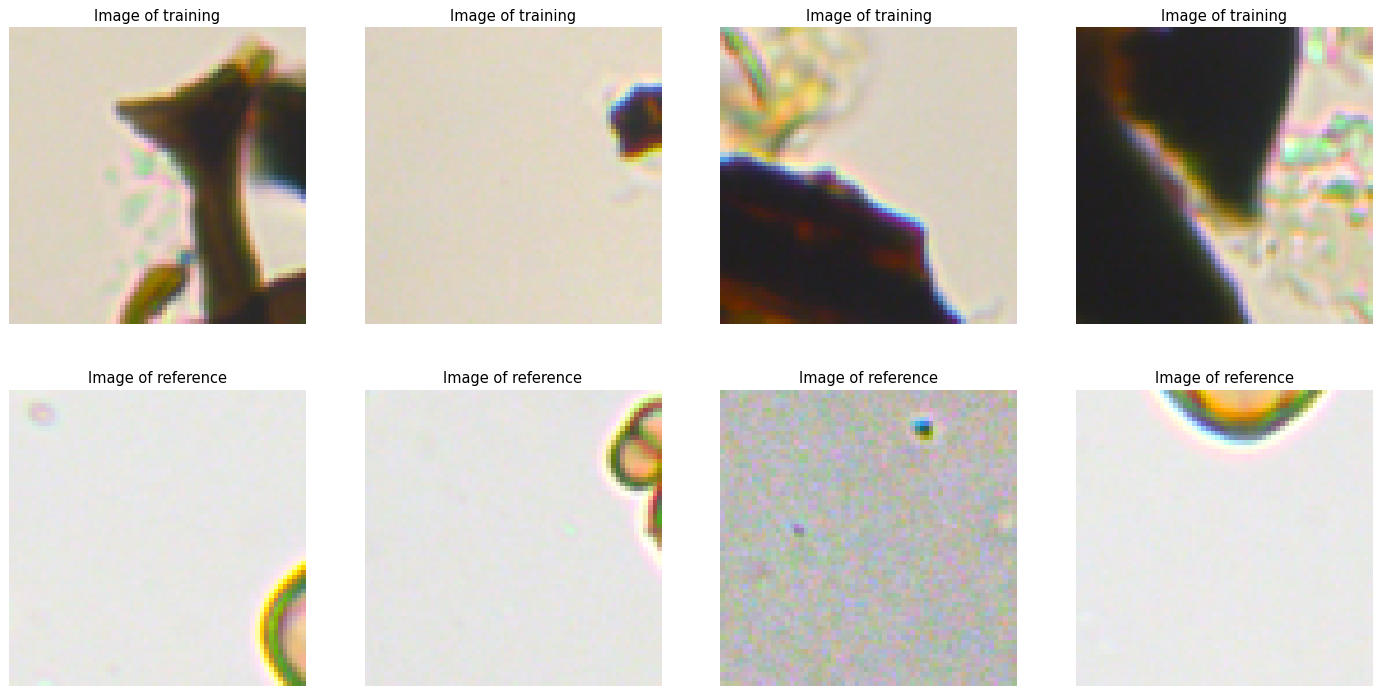

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2



sampler = iter(dataset)

sampleBatch = 1 ##even number

for i, data in enumerate(dataset):

  figWinNumHeight, figWinNumWidth, subwinCount = 2, 4, 1
  plt.figure(figsize=(20,10), dpi=88, facecolor='w', edgecolor='k') 
  plt.clf()

  for sampleIndex in range((sampleBatch - 1)* 4, sampleBatch * 4):
      # visualize image
      plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
      subwinCount += 1
      image = data["A"][sampleIndex].cpu().numpy().transpose((1,2,0))   
      image -= image.min()    
      image /= image.max() 
      plt.imshow(image)    
      plt.axis('off')
      plt.title('Image of training')

  for sampleIndex in range(sampleBatch * 4, (sampleBatch + 1)* 4):
      # visualize image
      plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
      subwinCount += 1
      image = data["B"][sampleIndex].cpu().numpy().transpose((1,2,0)) 
      image -= image.min()    
      image /= image.max() 
      plt.imshow(image)    
      plt.axis('off')
      plt.title('Image of reference')

  break


In [ ]:
$## initialize model

model = create_model(trainOPT)
model.setup(trainOPT)


initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
model [CycleGANModel] was created
---------- Networks initialized -------------
[Network G_A] Total number of parameters : 11.378 M
[Network G_B] Total number of parameters : 11.378 M
[Network D_A] Total number of parameters : 2.765 M
[Network D_B] Total number of parameters : 2.765 M
[Network CLS] Total number of parameters : 0.682 M
-----------------------------------------------


In [ ]:
## visualizer
#! python -m visdom.server

visualizer = Visualizer(trainOPT)

Setting up a new session...


create web directory ./checkpoints/cycada_svhn2mnist_noIdentity/web...


In [ ]:

total_steps = 0

for epoch in range(trainOPT.epoch_count, trainOPT.niter + trainOPT.niter_decay + 1):
    epoch_start_time = time.time()
    iter_data_time = time.time()
    epoch_iter = 0

    for i, data in enumerate(dataset):
        iter_start_time = time.time()
        if total_steps % trainOPT.print_freq == 0:
            t_data = iter_start_time - iter_data_time
        visualizer.reset()
        total_steps += trainOPT.batchSize
        epoch_iter += trainOPT.batchSize
        model.set_input(data)
        model.optimize_parameters()

        if total_steps % trainOPT.display_freq == 0:
            save_result = total_steps % trainOPT.update_html_freq == 0
            visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

        if total_steps % trainOPT.print_freq == 0:
            losses = model.get_current_losses()
            t = (time.time() - iter_start_time) / trainOPT.batchSize
            visualizer.print_current_losses(epoch, epoch_iter, losses, t, t_data)
            if trainOPT.display_id > 0:
                visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, trainOPT, losses)

        if total_steps % trainOPT.save_latest_freq == 0:
            print('saving the latest model (epoch %d, total_steps %d)' %
                  (epoch, total_steps))
            model.save_networks('latest')

        iter_data_time = time.time()
    if epoch % trainOPT.save_epoch_freq == 0:
        print('saving the model at the end of epoch %d, iters %d' %
              (epoch, total_steps))
        model.save_networks('latest')
        model.save_networks(epoch)

    print('End of epoch %d / %d \t Time Taken: %d sec' %
          (epoch, trainOPT.niter + trainOPT.niter_decay, time.time() - epoch_start_time))
    model.update_learning_rate()

Streaming output truncated to the last 5000 lines.
(epoch: 59, iters: 7800, time: 0.006, data: 0.003) D_A: 0.000 G_A: 2.013 cycle_A: 0.274 idt_A: 0.000 D_B: 0.002 G_B: 1.084 cycle_B: 0.049 idt_B: 0.000 sem_AB: 0.097 sem_BA: 0.097 CLS: 0.006 
(epoch: 59, iters: 7900, time: 0.004, data: 0.003) D_A: 0.000 G_A: 1.987 cycle_A: 0.308 idt_A: 0.000 D_B: 0.002 G_B: 0.923 cycle_B: 0.046 idt_B: 0.000 sem_AB: 0.101 sem_BA: 0.105 CLS: 0.002 
(epoch: 59, iters: 8000, time: 0.004, data: 0.003) D_A: 0.000 G_A: 2.014 cycle_A: 0.295 idt_A: 0.000 D_B: 0.002 G_B: 1.076 cycle_B: 0.047 idt_B: 0.000 sem_AB: 0.070 sem_BA: 0.068 CLS: 0.022 
(epoch: 59, iters: 8100, time: 0.004, data: 0.003) D_A: 0.000 G_A: 1.982 cycle_A: 0.311 idt_A: 0.000 D_B: 0.001 G_B: 0.930 cycle_B: 0.046 idt_B: 0.000 sem_AB: 0.332 sem_BA: 0.108 CLS: 0.101 
(epoch: 59, iters: 8200, time: 0.006, data: 0.003) D_A: 0.000 G_A: 2.013 cycle_A: 0.322 idt_A: 0.000 D_B: 0.001 G_B: 1.068 cycle_B: 0.049 idt_B: 0.000 sem_AB: 0.047 sem_BA: 0.158 CLS: 0